In [4]:
import ConfigParser
import io

# Load the configuration file
with open("example.ini") as f:
    sample_config = f.read()
config = ConfigParser.RawConfigParser(allow_no_value=True)
config.readfp(io.BytesIO(sample_config))



from __future__ import print_function
import keras
from keras.datasets import cifar10
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
import os

batch_size = int(config.get('parameters','batch_size'))
num_classes =int(config.get('parameters','num_classes'))
epochs = int(config.get('parameters','epochs'))
num_predictions = config.get('others','num_predictions')
conv2d=int(config.get('others','conv2d'))
conv2d1=int(config.get('others','conv2d1'))
verbose=config.get('others','verbose')
input_shape=config.get('others','input_shape')
data_augmentation = bool(config.get('others','data_augmentation'))
dense=int(config.get('others','dense'))
dropout=float(config.get('others','dropout'))
#print(batch_size)

save_dir = os.path.join(os.getcwd(), 'saved_models')
model_name = 'keras_cifar10_trained_model.h5'

# The data, shuffled and split between train and test sets:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')
# Convert class vectors to binary class matrices.
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

model = Sequential()
model.add(Conv2D(conv2d, (3, 3), padding='same',
                 input_shape=x_train.shape[1:]))


model.add(Activation('relu'))
model.add(Conv2D(conv2d, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(conv2d1, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(conv2d1, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
#model.add(Dropout(0.1))

model.add(Flatten())
model.add(Dense(dense))
model.add(Activation('relu'))
model.add(Dropout(dropout))
model.add(Dense(num_classes))
model.add(Activation('softmax'))

# initiate RMSprop optimizer
opt = keras.optimizers.rmsprop(lr=0.0001, decay=1e-6)

# Let's train the model using RMSprop
model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

if not data_augmentation:
    print('Not using data augmentation.')
    model.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=epochs,
              validation_data=(x_test, y_test),
              shuffle=True)
else:
    print('Using real-time data augmentation.')
    # This will do preprocessing and realtime data augmentation:
    datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=0,  # randomly rotate images in the range (degrees, 0 to 180)
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False)  # randomly flip images

    # Compute quantities required for feature-wise normalization
    # (std, mean, and principal components if ZCA whitening is applied).
    datagen.fit(x_train)

    # Fit the model on the batches generated by datagen.flow().
    history=model.fit_generator(datagen.flow(x_train, y_train,
                                     batch_size=batch_size),
                        epochs=epochs,
                        validation_data=(x_test, y_test),
                        workers=4)

# Save model and weights
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
model_path = os.path.join(save_dir, model_name)
model.save(model_path)
print('Saved trained model at %s ' % model_path)

# Score trained model.
scores = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples
Using real-time data augmentation.
Epoch 1/20
391/391 [==============================] - 21s 53ms/step - loss: 1.9252 - acc: 0.3058 - val_loss: 1.6826 - val_acc: 0.4094
Epoch 2/20
391/391 [==============================] - 20s 51ms/step - loss: 1.6515 - acc: 0.4072 - val_loss: 1.5004 - val_acc: 0.4654
Epoch 3/20
391/391 [==============================] - 20s 51ms/step - loss: 1.5408 - acc: 0.4487 - val_loss: 1.4281 - val_acc: 0.4886s - loss: 1.5430 - a
Epoch 4/20
391/391 [==============================] - 20s 51ms/step - loss: 1.4731 - acc: 0.4697 - val_loss: 1.3540 - val_acc: 0.5189
Epoch 5/20
391/391 [==============================] - 20s 51ms/step - loss: 1.4216 - acc: 0.4916 - val_loss: 1.3584 - val_acc: 0.5182
Epoch 6/20
391/391 [==============================] - 20s 51ms/step - loss: 1.3811 - acc: 0.5095 - val_loss: 1.2648 - val_acc: 0.5525
Epoch 7/20
391/391 [==============================] - 20s 52ms/step 

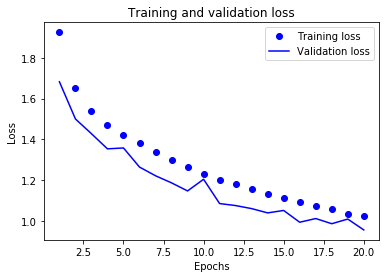

In [6]:
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

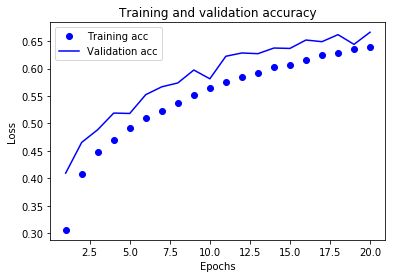

In [7]:
acc = history.history['acc']
val_acc = history.history['val_acc']

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [24]:
import ConfigParser
import io

# Load the configuration file
with open("example.ini") as f:
    sample_config = f.read()
config = ConfigParser.RawConfigParser(allow_no_value=True)
config.readfp(io.BytesIO(sample_config))
config.sections()

from __future__ import print_function
import keras
from keras.datasets import cifar10
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
import os

batch_size = int(config.get('parameters1','batch_size'))
num_classes =int(config.get('parameters1','num_classes'))
epochs = int(config.get('parameters1','epochs'))
num_predictions = config.get('others1','num_predictions')
conv2d=int(config.get('others1','conv2d'))
conv2d1=int(config.get('others1','conv2d1'))
verbose=config.get('others1','verbose')
input_shape=config.get('others1','input_shape')
data_augmentation = bool(config.get('others1','data_augmentation'))
dense=int(config.get('others1','dense'))
dropout=float(config.get('others','dropout'))

In [22]:
import ConfigParser
import io

# Load the configuration file
with open("example.ini") as f:
    sample_config = f.read()
config = ConfigParser.RawConfigParser(allow_no_value=True)
config.readfp(io.BytesIO(sample_config))
config.sections()


['parameters', 'others', 'parameters1', 'others1', 'parameters2', 'others2']

In [23]:
import ConfigParser
import io

# Load the configuration file
with open("example.ini") as f:
    sample_config = f.read()
config = ConfigParser.RawConfigParser(allow_no_value=True)
config.readfp(io.BytesIO(sample_config))



from __future__ import print_function
import keras
from keras.datasets import cifar10
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
import os

batch_size = int(config.get('parameters2','batch_size'))
num_classes =int(config.get('parameters2','num_classes'))
epochs = int(config.get('parameters2','epochs'))
num_predictions = config.get('others2','num_predictions')
conv2d=int(config.get('others2','conv2d'))
conv2d1=int(config.get('others2','conv2d1'))
verbose=config.get('others2','verbose')
input_shape=config.get('others2','input_shape')
data_augmentation = bool(config.get('others2','data_augmentation'))
dense=int(config.get('others2','dense'))
dropout=float(config.get('others','dropout'))

In [25]:
save_dir = os.path.join(os.getcwd(), 'saved_models')
model_name = 'keras_cifar10_trained_model.h5'

# The data, shuffled and split between train and test sets:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')
# Convert class vectors to binary class matrices.
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

model = Sequential()
model.add(Conv2D(conv2d, (3, 3), padding='same',
                 input_shape=x_train.shape[1:]))


model.add(Activation('relu'))
model.add(Conv2D(conv2d, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(conv2d1, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(conv2d1, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
#model.add(Dropout(0.1))

model.add(Flatten())
model.add(Dense(dense))
model.add(Activation('relu'))
model.add(Dropout(dropout))
model.add(Dense(num_classes))
model.add(Activation('softmax'))

# initiate RMSprop optimizer
opt = keras.optimizers.rmsprop(lr=0.0001, decay=1e-6)

# Let's train the model using RMSprop
model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

if not data_augmentation:
    print('Not using data augmentation.')
    model.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=epochs,
              validation_data=(x_test, y_test),
              shuffle=True)
else:
    print('Using real-time data augmentation.')
    # This will do preprocessing and realtime data augmentation:
    datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=0,  # randomly rotate images in the range (degrees, 0 to 180)
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False)  # randomly flip images

    # Compute quantities required for feature-wise normalization
    # (std, mean, and principal components if ZCA whitening is applied).
    datagen.fit(x_train)

    # Fit the model on the batches generated by datagen.flow().
    history=model.fit_generator(datagen.flow(x_train, y_train,
                                     batch_size=batch_size),
                        epochs=epochs,
                        validation_data=(x_test, y_test),
                        workers=4)

# Save model and weights
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
model_path = os.path.join(save_dir, model_name)
model.save(model_path)
print('Saved trained model at %s ' % model_path)

# Score trained model.
scores = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples
Using real-time data augmentation.
Epoch 1/100
391/391 [==============================] - 21s 53ms/step - loss: 1.8732 - acc: 0.3219 - val_loss: 1.6320 - val_acc: 0.4100
Epoch 2/100
391/391 [==============================] - 20s 52ms/step - loss: 1.6133 - acc: 0.4157 - val_loss: 1.4879 - val_acc: 0.4711
Epoch 3/100
391/391 [==============================] - 20s 52ms/step - loss: 1.4973 - acc: 0.4599 - val_loss: 1.4028 - val_acc: 0.4967
Epoch 4/100
391/391 [==============================] - 20s 52ms/step - loss: 1.4304 - acc: 0.4852 - val_loss: 1.3096 - val_acc: 0.5322
Epoch 5/100
391/391 [==============================] - 20s 52ms/step - loss: 1.3711 - acc: 0.5114 - val_loss: 1.2314 - val_acc: 0.5643
Epoch 6/100
391/391 [==============================] - 20s 52ms/step - loss: 1.3225 - acc: 0.5310 - val_loss: 1.2402 - val_acc: 0.5569
Epoch 7/100
391/391 [==============================] - 20s 52ms/step - loss: 1.273

391/391 [==============================] - 20s 52ms/step - loss: 0.5526 - acc: 0.8087 - val_loss: 0.5748 - val_acc: 0.8023
Epoch 61/100
391/391 [==============================] - 20s 52ms/step - loss: 0.5453 - acc: 0.8110 - val_loss: 0.5703 - val_acc: 0.8014
Epoch 62/100
391/391 [==============================] - 20s 52ms/step - loss: 0.5455 - acc: 0.8121 - val_loss: 0.5695 - val_acc: 0.8013
Epoch 63/100
391/391 [==============================] - 20s 52ms/step - loss: 0.5392 - acc: 0.8137 - val_loss: 0.5590 - val_acc: 0.8064
Epoch 64/100
391/391 [==============================] - 20s 52ms/step - loss: 0.5321 - acc: 0.8142 - val_loss: 0.5755 - val_acc: 0.8016
Epoch 65/100
391/391 [==============================] - 20s 51ms/step - loss: 0.5277 - acc: 0.8178 - val_loss: 0.5647 - val_acc: 0.8049
Epoch 66/100
391/391 [==============================] - 20s 51ms/step - loss: 0.5220 - acc: 0.8187 - val_loss: 0.5549 - val_acc: 0.8054
Epoch 67/100
391/391 [==============================] - 20s 5

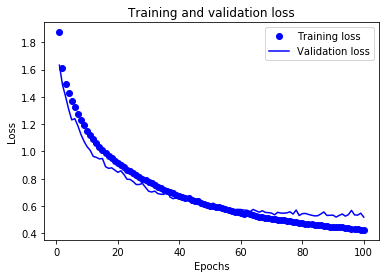

In [26]:
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

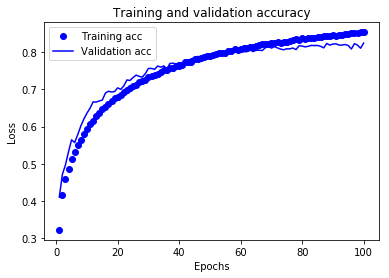

In [27]:
acc = history.history['acc']
val_acc = history.history['val_acc']

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [8]:


from __future__ import print_function
import keras
from keras.datasets import cifar10
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
import os

batch_size = 32
num_classes = 10
epochs = 30
data_augmentation = True
num_predictions = 20
save_dir = os.path.join(os.getcwd(), 'saved_models')
model_name = 'keras_cifar10_trained_model.h5'

# The data, shuffled and split between train and test sets:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# Convert class vectors to binary class matrices.
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

model = Sequential()
model.add(Conv2D(32, (3, 3), padding='same',
                 input_shape=x_train.shape[1:]))
model.add(Activation('relu'))
model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
#model.add(Dropout(0.25))
#model.add(Flatten())

model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
#model.add(Dropout(0.3))

model.add(Flatten())
model.add(Dense(128))
model.add(Activation('relu'))
#model.add(Dropout(0.1))
model.add(Dense(num_classes))
model.add(Activation('softmax'))

# initiate RMSprop optimizer
opt = keras.optimizers.rmsprop(lr=0.0001, decay=1e-6)

# Let's train the model using RMSprop
model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

if not data_augmentation:
    print('Not using data augmentation.')
    model.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=epochs,
              validation_data=(x_test, y_test),
              shuffle=True)
else:
    print('Using real-time data augmentation.')
    # This will do preprocessing and realtime data augmentation:
    datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=0,  # randomly rotate images in the range (degrees, 0 to 180)
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False)  # randomly flip images

    # Compute quantities required for feature-wise normalization
    # (std, mean, and principal components if ZCA whitening is applied).
    datagen.fit(x_train)

    # Fit the model on the batches generated by datagen.flow().
    history=model.fit_generator(datagen.flow(x_train, y_train,
                                     batch_size=batch_size),
                        epochs=epochs,
                        validation_data=(x_test, y_test),
                        workers=4)

# Save model and weights
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
model_path = os.path.join(save_dir, model_name)
model.save(model_path)
print('Saved trained model at %s ' % model_path)

# Score trained model.
scores = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples
Using real-time data augmentation.
Epoch 1/30
1563/1563 [==============================] - 26s 17ms/step - loss: 1.7840 - acc: 0.3562 - val_loss: 1.5821 - val_acc: 0.4354
Epoch 2/30
1563/1563 [==============================] - 25s 16ms/step - loss: 1.5142 - acc: 0.4551 - val_loss: 1.3625 - val_acc: 0.5101
Epoch 3/30
1563/1563 [==============================] - 25s 16ms/step - loss: 1.3929 - acc: 0.5021 - val_loss: 1.2610 - val_acc: 0.5535
Epoch 4/30
1563/1563 [==============================] - 25s 16ms/step - loss: 1.2989 - acc: 0.5406 - val_loss: 1.2047 - val_acc: 0.5776
Epoch 5/30
1563/1563 [==============================] - 25s 16ms/step - loss: 1.2149 - acc: 0.5734 - val_loss: 1.1463 - val_acc: 0.6016
Epoch 6/30
1563/1563 [==============================] - 25s 16ms/step - loss: 1.1472 - acc: 0.5984 - val_loss: 1.0257 - val_acc: 0.6428
Epoch 7/30
1563/1563 [==============================] - 25s 16ms/step - loss

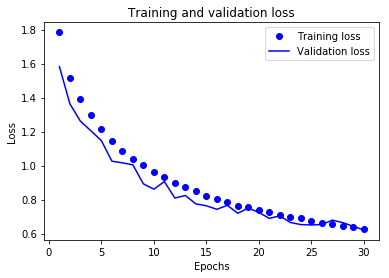

In [10]:
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()


In [11]:


from __future__ import print_function
import keras
from keras.datasets import cifar10
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
import os

batch_size = 32
num_classes = 10
epochs = 30
data_augmentation = True
num_predictions = 20
save_dir = os.path.join(os.getcwd(), 'saved_models')
model_name = 'keras_cifar10_trained_model.h5'

# The data, shuffled and split between train and test sets:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# Convert class vectors to binary class matrices.
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

model = Sequential()
model.add(Conv2D(32, (3, 3), padding='same',
                 input_shape=x_train.shape[1:]))
model.add(Activation('relu'))
model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
#model.add(Dropout(0.25))
#model.add(Flatten())

model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
#model.add(Dropout(0.3))

model.add(Flatten())
model.add(Dense(128))
model.add(Activation('relu'))
#model.add(Dropout(0.1))
model.add(Dense(256))
model.add(Dense(num_classes))
model.add(Activation('softmax'))

# initiate RMSprop optimizer
opt = keras.optimizers.rmsprop(lr=0.0001, decay=1e-6)

# Let's train the model using RMSprop
model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

if not data_augmentation:
    print('Not using data augmentation.')
    model.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=epochs,
              validation_data=(x_test, y_test),
              shuffle=True)
else:
    print('Using real-time data augmentation.')
    # This will do preprocessing and realtime data augmentation:
    datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=0,  # randomly rotate images in the range (degrees, 0 to 180)
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False)  # randomly flip images

    # Compute quantities required for feature-wise normalization
    # (std, mean, and principal components if ZCA whitening is applied).
    datagen.fit(x_train)

    # Fit the model on the batches generated by datagen.flow().
    history=model.fit_generator(datagen.flow(x_train, y_train,
                                     batch_size=batch_size),
                        epochs=epochs,
                        validation_data=(x_test, y_test),
                        workers=4)

# Save model and weights
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
model_path = os.path.join(save_dir, model_name)
model.save(model_path)
print('Saved trained model at %s ' % model_path)

# Score trained model.
scores = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples
Using real-time data augmentation.
Epoch 1/30
1563/1563 [==============================] - 25s 16ms/step - loss: 1.7855 - acc: 0.3497 - val_loss: 1.5601 - val_acc: 0.4428
Epoch 2/30
1563/1563 [==============================] - 25s 16ms/step - loss: 1.4975 - acc: 0.4602 - val_loss: 1.3112 - val_acc: 0.5321
Epoch 3/30
1563/1563 [==============================] - 25s 16ms/step - loss: 1.3496 - acc: 0.5157 - val_loss: 1.2375 - val_acc: 0.5580
Epoch 4/30
1563/1563 [==============================] - 25s 16ms/step - loss: 1.2368 - acc: 0.5596 - val_loss: 1.1432 - val_acc: 0.5918
Epoch 5/30
1563/1563 [==============================] - 25s 16ms/step - loss: 1.1518 - acc: 0.5928 - val_loss: 1.0491 - val_acc: 0.6300
Epoch 6/30
1563/1563 [==============================] - 25s 16ms/step - loss: 1.0878 - acc: 0.6162 - val_loss: 0.9862 - val_acc: 0.6516
Epoch 7/30
1563/1563 [==============================] - 25s 16ms/step - loss

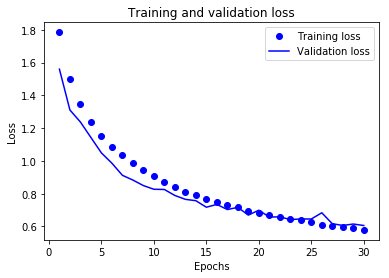

In [12]:
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()


In [13]:


from __future__ import print_function
import keras
from keras.datasets import cifar10
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
import os

batch_size = 32
num_classes = 10
epochs = 30
data_augmentation = True
num_predictions = 20
save_dir = os.path.join(os.getcwd(), 'saved_models')
model_name = 'keras_cifar10_trained_model.h5'

# The data, shuffled and split between train and test sets:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# Convert class vectors to binary class matrices.
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

model = Sequential()
model.add(Conv2D(32, (3, 3), padding='same',
                 input_shape=x_train.shape[1:]))
model.add(Activation('relu'))
model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
#model.add(Dropout(0.25))
#model.add(Flatten())

model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
#model.add(Dropout(0.3))

model.add(Flatten())
model.add(Dense(128))
model.add(Activation('relu'))
#model.add(Dropout(0.1))
model.add(Dense(256))
model.add(Dense(num_classes))
model.add(Activation('softmax'))

# initiate RMSprop optimizer
keras.optimizers.Adagrad(lr=0.01, epsilon=None, decay=0.0)

# Let's train the model using RMSprop
model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

if not data_augmentation:
    print('Not using data augmentation.')
    model.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=epochs,
              validation_data=(x_test, y_test),
              shuffle=True)
else:
    print('Using real-time data augmentation.')
    # This will do preprocessing and realtime data augmentation:
    datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=0,  # randomly rotate images in the range (degrees, 0 to 180)
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False)  # randomly flip images

    # Compute quantities required for feature-wise normalization
    # (std, mean, and principal components if ZCA whitening is applied).
    datagen.fit(x_train)

    # Fit the model on the batches generated by datagen.flow().
    history=model.fit_generator(datagen.flow(x_train, y_train,
                                     batch_size=batch_size),
                        epochs=epochs,
                        validation_data=(x_test, y_test),
                        workers=4)

# Save model and weights
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
model_path = os.path.join(save_dir, model_name)
model.save(model_path)
print('Saved trained model at %s ' % model_path)

# Score trained model.
scores = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])




x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples
Using real-time data augmentation.
Epoch 1/30
1563/1563 [==============================] - 26s 16ms/step - loss: 1.7701 - acc: 0.3585 - val_loss: 1.4890 - val_acc: 0.4578
Epoch 2/30
1563/1563 [==============================] - 25s 16ms/step - loss: 1.4917 - acc: 0.4563 - val_loss: 1.3376 - val_acc: 0.5286
Epoch 3/30
1563/1563 [==============================] - 25s 16ms/step - loss: 1.3625 - acc: 0.5090 - val_loss: 1.2280 - val_acc: 0.5629
Epoch 4/30
1563/1563 [==============================] - 25s 16ms/step - loss: 1.2616 - acc: 0.5495 - val_loss: 1.1377 - val_acc: 0.6021
Epoch 5/30
1563/1563 [==============================] - 25s 16ms/step - loss: 1.1762 - acc: 0.5814 - val_loss: 1.0880 - val_acc: 0.6111
Epoch 6/30
1563/1563 [==============================] - 25s 16ms/step - loss: 1.1037 - acc: 0.6068 - val_loss: 1.0164 - val_acc: 0.6449
Epoch 7/30
1563/1563 [==============================] - 25s 16ms/step - loss

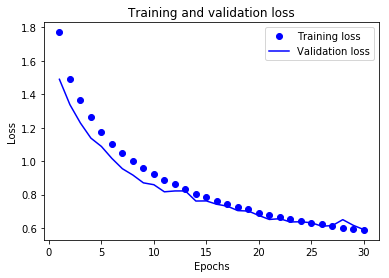

In [14]:
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
